# 0. Imports

In [1]:
import sys

sys.path.append("src/")

from object_detection import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split

import torch

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# 1. Model Read In

In [2]:
model = torch.load("detector_model.pt")

In [3]:
model

ObjectDetector(
  (model): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
           

# 2. Validation Data Read In

In [4]:
img_root_path = Path("../data/car-object-detection/training_images")

In [5]:
df = pd.read_csv("../data/car-object-detection/train_solution_bounding_boxes (1).csv")
df["bbox_width"] = df["xmax"] - df["xmin"]
df["bbox_height"] = df["ymax"] - df["ymin"]
df["area"] = df["bbox_width"] * df["bbox_height"]
df = df.groupby("image").agg(list)
df.reset_index(inplace=True)

In [6]:
train_df, val_df = train_test_split(df, test_size=0.1, shuffle=False)
train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)

In [7]:
transforms = A.Compose(
    [
        A.Resize(256, 256, p=1.0),  # resize the image
        ToTensorV2(p=1.0),
    ],
    bbox_params={"format": "pascal_voc", "label_fields": ["labels"]},
)  # bounding box parameters

In [8]:
val_ds = LoadDataset(val_df, img_root_path, transforms)

# 3. Validation of Model

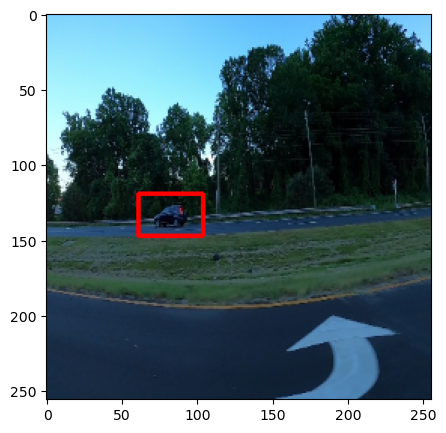

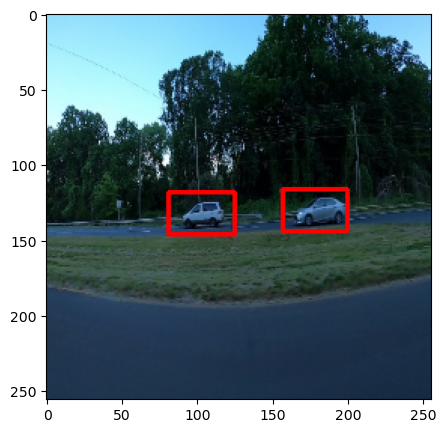

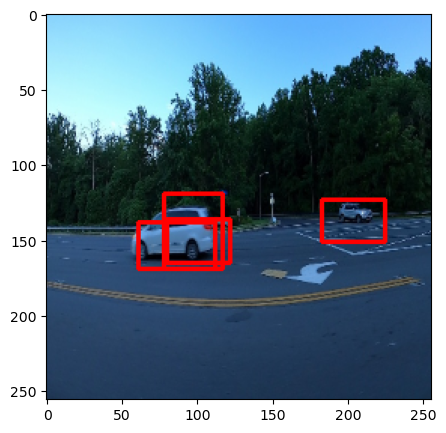

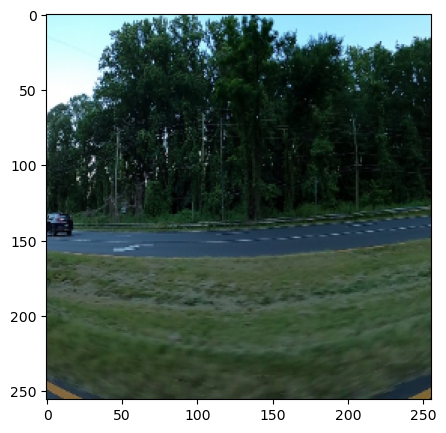

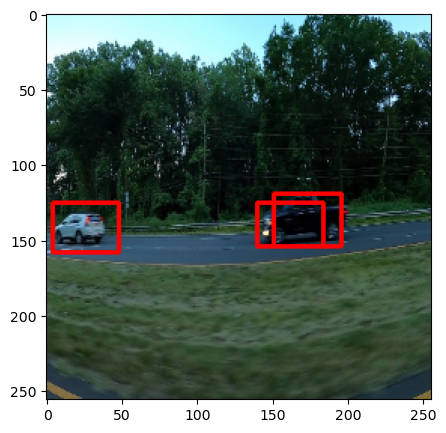

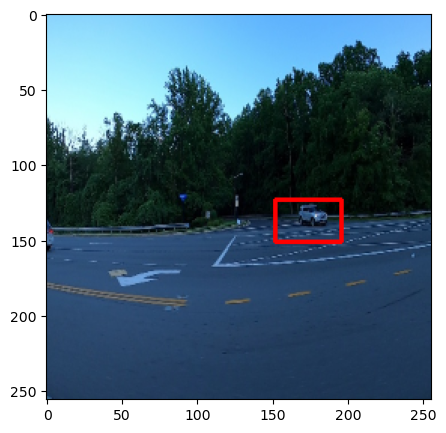

In [9]:
for idx in range(2, 20, 3):
    sample = val_ds[idx]
    img = sample[0]
    model.eval()
    with torch.no_grad():
        out = model([img])
    img = img.permute(1, 2, 0).numpy()  # convert to numpy for opencv to draw bboxes
    pred_bbox = out[0]["boxes"].numpy().astype(int)  # predicted bounding boxes
    pred_label = out[0]["scores"]  # predicted labels
    # draw bounding boxes on the image
    for bbox, label in zip(pred_bbox, pred_label):
        # check if the label corresponding to bbox is for car
        if label >= 0.5:
            cv2.rectangle(
                img,
                (bbox[0], bbox[1]),
                (bbox[2], bbox[3]),
                (255, 0, 0),
                thickness=2,
            )
    plt.figure(figsize=(5, 5))
    img = np.clip(img, 0, 1)
    plt.imshow(img)